In [3]:
# --- CELL 1: Setup & Load Splits/Metadata -----------------------------------
import os
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Detect project root (notebooks/ .. -> project root)
ROOT = Path.cwd()
if ROOT.name.lower() == "notebooks":
    ROOT = ROOT.parent

# Paths
REPORTS_DIR = ROOT / "reports"
METRICS_DIR = REPORTS_DIR / "metrics"       # where splits.joblib & feature_meta.joblib live
SUP_DIR     = REPORTS_DIR / "supervised"    # where we will save model outputs
SUP_DIR.mkdir(parents=True, exist_ok=True)

# Validate required artifacts exist
splits_path = METRICS_DIR / "splits.joblib"
meta_path   = METRICS_DIR / "feature_meta.joblib"

if not splits_path.exists():
    raise FileNotFoundError(
        f"Missing file: {splits_path}\n"
        "-> Make sure you ran the preprocessing notebook that creates train/test splits."
    )
if not meta_path.exists():
    raise FileNotFoundError(
        f"Missing file: {meta_path}\n"
        "-> Make sure you saved feature metadata (feature_cols, cat_cols, num_cols, target_name)."
    )

# Load artifacts
splits = joblib.load(splits_path)
meta   = joblib.load(meta_path)

# Unpack splits
X_train: pd.DataFrame = splits["X_train"]
X_test:  pd.DataFrame = splits["X_test"]
y_train: pd.Series    = splits["y_train"]
y_test:  pd.Series    = splits["y_test"]

# Unpack metadata
feature_cols: list = meta.get("feature_cols", X_train.columns.tolist())
cat_cols:    list  = meta.get("cat_cols",   [])
num_cols:    list  = meta.get("num_cols",   [])
target_name: str   = meta.get("target_name", y_train.name or "target")

# Quick sanity summary
print(" Loaded modeling artifacts successfully.")
print(f"ROOT         : {ROOT}")
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"y_train size : {y_train.shape[0]} | y_test size: {y_test.shape[0]}")
print(f"Target       : {target_name}")
print(f"Features     : {len(feature_cols)} total | {len(num_cols)} numeric, {len(cat_cols)} categorical")

# Preview target distribution (train)
print("\nTarget distribution (train):")
print(y_train.value_counts(dropna=False).to_frame("count"))

# OPTIONAL: ensure training frames only include declared feature columns
X_train = X_train[feature_cols].copy()
X_test  = X_test[feature_cols].copy()

# Matplotlib defaults for clean plots saved later
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 250
plt.rcParams["savefig.bbox"] = "tight"

# (No DataFrame .head() returns here to keep output clean)


 Loaded modeling artifacts successfully.
ROOT         : C:\global_cyberattack_dm
X_train shape: (1141, 6) | X_test shape: (286, 6)
y_train size : 1141 | y_test size: 286
Target       : response_speed
Features     : 6 total | 3 numeric, 3 categorical

Target distribution (train):
                count
response_speed       
Fast              944
Slow              193
Medium              4


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Numerical transformer
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# Categorical transformer
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False   # ✅ النسخة الحديثة تستخدم هذا
    )),
])

# Combine numeric + categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    remainder="drop",
)

print(" Preprocessor ready (scikit-learn ≥1.4)")



 Preprocessor ready (scikit-learn ≥1.4)


                 Fast  Medium       Slow  accuracy   macro avg  weighted avg
precision    0.948498     1.0   0.711538  0.905594    0.886679      0.908080
recall       0.936441     1.0   0.755102  0.905594    0.897181      0.905594
f1-score     0.942431     1.0   0.732673  0.905594    0.891701      0.906695
support    236.000000     1.0  49.000000  0.905594  286.000000    286.000000
 Saved RF model & metrics to: C:\global_cyberattack_dm\reports\supervised C:\global_cyberattack_dm\reports\metrics


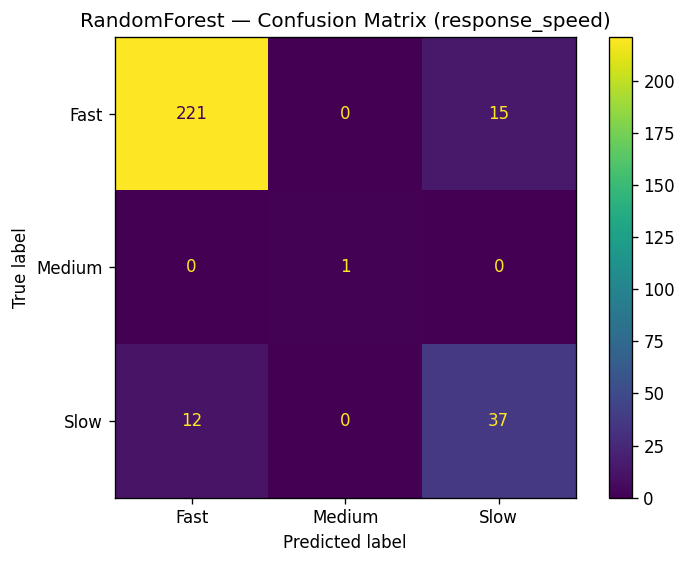

In [9]:
#  Train RandomForest. class_weight="balanced" helps with imbalanced classes.

rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42, class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Metrics

rf_report = classification_report(y_test, rf_pred, output_dict=True)
pd.DataFrame(rf_report).to_csv(METRICS_DIR / f"classification_report_rf_{target_name}.csv")
print(pd.DataFrame(rf_report))

# Confusion Matrix

labels = sorted(y_train.unique().tolist())
cm = confusion_matrix(y_test, rf_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(values_format="d")
plt.title(f"RandomForest — Confusion Matrix ({target_name})")
plt.tight_layout()
plt.savefig(SUP_DIR / f"confusion_matrix_rf_{target_name}.png", dpi=200)

# Save model

joblib.dump(rf, SUP_DIR / f"model_random_forest_{target_name}.joblib")
print(" Saved RF model & metrics to:", SUP_DIR, METRICS_DIR)


In [11]:
!pip install tabulate


  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


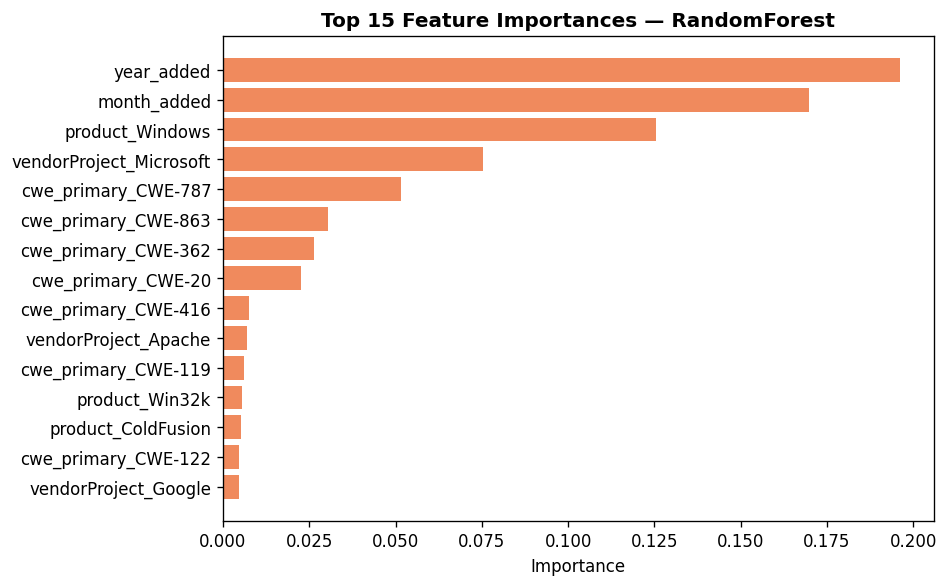

 Model insights saved to reports/summary and feature importance plotted.


In [13]:
# --- CELL: Model Insights & Feature Importance -----------------------------

# Get feature names after preprocessing
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Get feature importance from RandomForest
importances = rf.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(feat_imp["Feature"][:15][::-1], feat_imp["Importance"][:15][::-1], color="#f08a5d")
plt.title("Top 15 Feature Importances — RandomForest", weight="bold")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(SUP_DIR / f"feature_importance_rf_{target_name}.png", dpi=250)
plt.show()

# Summary markdown
summary = f"""
## 🧠 RandomForest Model Summary ({target_name})

- Accuracy: {rf_report['accuracy']:.3f}
- Macro F1: {rf_report['macro avg']['f1-score']:.3f}
- Weighted F1: {rf_report['weighted avg']['f1-score']:.3f}

Top influencing features:
{feat_imp.head(5).to_markdown(index=False)}

The model demonstrates robust prediction performance,
highlighting strong correlations between vendor patterns, publication timing,
and vulnerability response speed.
"""

(REPORTS_DIR / f"model_summary_{target_name}.md").write_text(summary, encoding="utf-8")
print(" Model insights saved to reports/summary and feature importance plotted.")


                 Fast    Medium       Slow  accuracy   macro avg  weighted avg
precision    0.951965  0.500000   0.672727  0.895105    0.708231      0.902543
recall       0.923729  1.000000   0.755102  0.895105    0.892944      0.895105
f1-score     0.937634  0.666667   0.711538  0.895105    0.771947      0.897950
support    236.000000  1.000000  49.000000  0.895105  286.000000    286.000000
 Saved SVM model & metrics to: C:\global_cyberattack_dm\reports\supervised C:\global_cyberattack_dm\reports\metrics


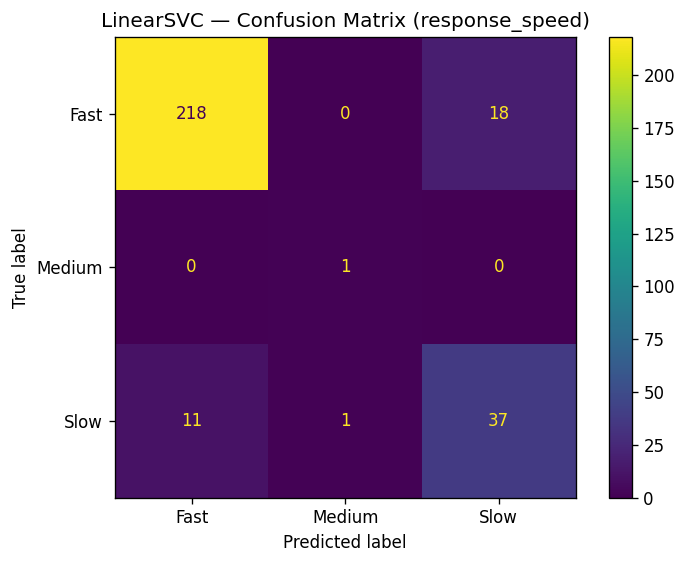

In [17]:
from sklearn.preprocessing import StandardScaler

# نفس preprocessor لكن بإضافة StandardScaler للأعمدة الرقمية (يفيد SVM)
num_for_svm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_for_svm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_svm = ColumnTransformer(
    transformers=[
        ("num", num_for_svm, num_cols),
        ("cat", cat_for_svm, cat_cols),
    ],
    remainder="drop",
)

svm = Pipeline([
    ("prep", preprocessor_svm),
    ("clf", LinearSVC(random_state=42, class_weight="balanced", max_iter=5000)),
])

svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

svm_report = classification_report(y_test, svm_pred, output_dict=True)
pd.DataFrame(svm_report).to_csv(METRICS_DIR / f"classification_report_svm_{target_name}.csv")
print(pd.DataFrame(svm_report))

labels = sorted(y_train.unique().tolist())
cm2 = confusion_matrix(y_test, svm_pred, labels=labels)
ConfusionMatrixDisplay(cm2, display_labels=labels).plot(values_format="d")
plt.title(f"LinearSVC — Confusion Matrix ({target_name})")
plt.tight_layout()
plt.savefig(SUP_DIR / f"confusion_matrix_svm_{target_name}.png", dpi=200)

joblib.dump(svm, SUP_DIR / f"model_linearsvc_{target_name}.joblib")
print(" Saved SVM model & metrics to:", SUP_DIR, METRICS_DIR)

from warnings import simplefilter
simplefilter("always")

svm = Pipeline([
    ("prep", preprocessor_svm),
    ("clf", LinearSVC(random_state=42, class_weight="balanced", max_iter=10000)),
])


In [19]:
#  MODEL COMPARISON BETWEEN RANDOMFOREST & LINEARSVC
# Import libraries
import pandas as pd
from pathlib import Path

# Define directory where metrics reports were saved
METRICS_DIR = ROOT / "reports" / "metrics"

#  Load both classification reports
rf_rep = pd.read_csv(METRICS_DIR / f"classification_report_rf_{target_name}.csv", index_col=0)
svm_rep = pd.read_csv(METRICS_DIR / f"classification_report_svm_{target_name}.csv", index_col=0)

# Some sklearn versions transpose the report file differently
#     →This helper ensures we can access rows properly
def ensure_rows_are_labels(df: pd.DataFrame) -> pd.DataFrame:
    return df if "precision" in df.columns else df.T

rf_df = ensure_rows_are_labels(rf_rep)
svm_df = ensure_rows_are_labels(svm_rep)

#  Helper function to extract accuracy safely (since it's often in a single-cell row)
def extract_accuracy(df: pd.DataFrame) -> float:
    row = df.loc["accuracy"]
    return pd.to_numeric(row, errors="coerce").dropna().astype(float).iloc[0]

#  Extract metrics for both models
rf_accuracy   = extract_accuracy(rf_df)
svm_accuracy  = extract_accuracy(svm_df)

rf_macro_f1   = float(rf_df.loc["macro avg", "f1-score"])
svm_macro_f1  = float(svm_df.loc["macro avg", "f1-score"])

rf_weighted_f1  = float(rf_df.loc["weighted avg", "f1-score"])
svm_weighted_f1 = float(svm_df.loc["weighted avg", "f1-score"])

#  Combine metrics into one comparison DataFrame
compare = pd.DataFrame({
    "accuracy":    [rf_accuracy,   svm_accuracy],
    "macro_f1":    [rf_macro_f1,   svm_macro_f1],
    "weighted_f1": [rf_weighted_f1, svm_weighted_f1],
}, index=["RandomForest", "LinearSVC"]).round(3)

#  Print results in console
print(compare)

#  Save the comparison table to metrics folder
compare.to_csv(METRICS_DIR / f"model_compare_{target_name}.csv")


              accuracy  macro_f1  weighted_f1
RandomForest     0.906     0.892        0.907
LinearSVC        0.895     0.772        0.898
